## 1. 门控循环单元（gated recurrent unit，GRU）
---

通过门控机制（Gated Mechanism）动态控制信息的流动，平衡长期记忆和短期输入的权重。

传统RNN通过隐藏状态传递信息，但随着时间步增加，梯度可能消失或爆炸，导致难以捕捉长期依赖。GRU通过引入更新门和重置门，让模型自主决定何时保留旧信息、何时更新新信息，从而更好地建模长序列。

In [5]:
from IPython.display import Image, display
url = 'https://zh.d2l.ai/_images/gru-3.svg'
display(Image(url=url, width=400))

## 2. 数学表达式

为了捕获长期记忆和短期输入，希望有一个概率分布$p(x)$使得$t$时刻的隐藏状态等于：
$$H_t=p(x)H_{t-1}+(1-p(x))\hat H_{t}$$
其中，$H_{t-1}$表示长期记忆；$\hat H_{t}$代表短期输入，也就是候选隐状态。

构造$p(x)$，也就是GRU中的更新门$Z_t$，使得其成为一个**可学习**的概率分布，即：
$$p(x)=Z_t=\sigma(W_{hz}H_{t-1}+W_{xz}X_t+b_z) $$
候选隐状态需要区别于$H_{t-1}$，即要对其进行限制，类似的构造一个概率分布$q(x)$**作用**在$H_{t-1}$上。这个$q(x)$即是GRU中的重置门。
$$q(x)=R_t=\sigma(W_{hr}H_{t-1}+W_{xr}X_t+b_r) $$
$$\hat H_{t}=\phi(W_{hh}(R_t\odot H_{t-1})+W_{xh}X_t+b_h) $$

整理后有：$$H_t=Z_t\odot H_{t-1}+(1-Z_t)\odot \hat H_{t}$$

$t$时刻的预测输出：$\hat X_t = \phi(W_{hx}H_{t}+b)$

## 3. 文本分类

基于以 imdb 数据集，实现了一个基本的 RNN 文本分类任务

### 3.1 导入必要的包

In [18]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

### 3.2 设定超参数

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3 #学习率
batch_size = 16 # 批次大小
epochs = 20 # 训练轮次

### 3.3 处理数据

In [8]:
# 加载IMDB数据集
dataset = load_dataset("imdb", cache_dir='./data')

In [9]:
# 分词器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir='./cache') # BERT Tokenizer 使用的是 WordPiece 算法

In [10]:
# 定义预处理函数
def preprocess_function(dataset):
    return tokenizer(dataset['text'], padding='max_length', truncation=True, max_length=300)
    
# 应用预处理
train_dataset = dataset['train'].map(preprocess_function, batched=True)
test_dataset = dataset['test'].map(preprocess_function, batched=True)

# 转换为 torch.Tensor
def format_dataset(dataset):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset

# 应用格式化
train_dataset = format_dataset(train_dataset)
test_dataset = format_dataset(test_dataset)

# 定义 collate_fn
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': labels
    }

# 创建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

### 3.4 定义网络

In [11]:
# 定义 RNN 模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.gru = nn.GRU(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = out[:, -1, :]  # 获取序列的最后一个输出
        out = self.fc(out)
        return self.softmax(out)

### 3.5 实例化模型

In [12]:
# BERT的词汇表大小为 30,000，隐藏层维度为128，输出类别数为2（正面或负面）
model = RNNModel(input_dim=30000, hidden_dim=128, output_dim=2)

In [13]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
RNNModel                                 --
├─Embedding: 1-1                         3,840,000
├─GRU: 1-2                               99,072
├─Linear: 1-3                            258
├─Softmax: 1-4                           --
Total params: 3,939,330
Trainable params: 3,939,330
Non-trainable params: 0

### 3.6 选择损失函数和优化器

In [14]:
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(device)
scaler = torch.amp.GradScaler()

In [15]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    correct_num = 0
    total_num = 0
    
    # 遍历训练数据
    for batch in train_dataloader:
        # 将数据和标签挪到GPU  
        data = batch['input_ids'].to(device)
        label = batch['label'].to(device)
        
        optimizer.zero_grad() # 梯度清理
        with torch.amp.autocast(device_type='cuda'):
            output = model(data)
            loss = criterion(output, label)
        # 使用 GradScaler 进行 loss 反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()  #计算总损失
        preds = torch.argmax(output, dim=1)
        correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
        total_num += label.size(0) # 总预测数量

        #手动释放显存
        del data, label, output, loss
        torch.cuda.empty_cache()

    train_loss = train_loss/len(train_dataloader) # 计算平均训练损失
    accuracy = correct_num/total_num # 计算准确率
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch:{epoch}\tTraining Loss:{train_loss:.6f}, Accuracy:{accuracy:.6f}') # 输出信息

In [16]:
# 定义验证函数并初始化
def evaluate(epoch): 
    model.eval() # 验证模式
    evaluate_loss = 0 #累积验证损失
    correct_num = 0 
    total_num = 0 
    
    # 禁用梯度
    with torch.no_grad():
        # 遍历测试数据
        for batch in test_dataloader: 
            # 将数据和标签挪到GPU  
            data = batch['input_ids'].to(device)
            label = batch['label'].to(device)
            with torch.amp.autocast(device_type='cuda'):  # 同样使用半精度
                output = model(data)
                loss = criterion(output, label)

            evaluate_loss += loss.item() # 累积总损失
            preds = torch.argmax(output, dim=1)
            correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
            total_num += label.size(0) # 总预测数量
    accuracy = correct_num/total_num # 计算准确率
    evaluate_loss = evaluate_loss/total_num # 计算平均验证损失
    test_accuracies.append(accuracy)
    print(f'Epoch:{epoch}\tValidation Loss:{evaluate_loss:.6f}, Accuracy:{accuracy:.6f}') #打印输出信息

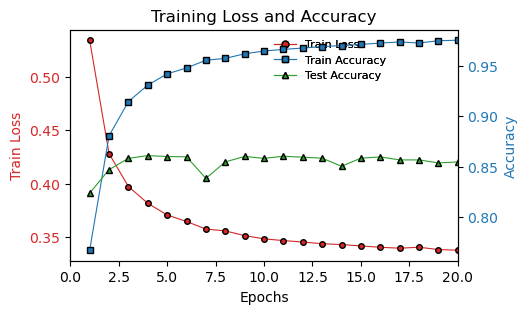

In [19]:
# 初始化数据
train_losses = []
train_accuracies = []
test_accuracies = []

# 设置 x 轴范围
initial_x_range = 10
x_range = initial_x_range  # 初始的 x 轴范围

# 画图函数
def plot_graph(epoch):
    global x_range

    # 如果 epoch 数量大于 x 轴范围的上限，就扩展 x 轴范围
    if epoch > x_range:
        x_range += 10
    
    clear_output(wait=True)  # 清除上一次的图表
    
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制训练损失（左 y 轴）
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color='tab:red')
    ax1.plot(range(1, len(train_losses) + 1), train_losses, color='tab:red', label='Train Loss', linewidth=0.8, marker='o', markersize=4, markeredgecolor='black')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_xlim(0, x_range)

    # 创建右侧 y 轴（准确率）
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, color='tab:blue', label='Train Accuracy', linewidth=0.8, marker='s', markersize=4, markeredgecolor='black')
    ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, color='tab:green', label='Test Accuracy', linewidth=0.8, marker='^', markersize=4, markeredgecolor='black')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 获取 ax1 和 ax2 的图例并合并
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2

    # 添加合并后的图例
    legend = ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.65, 1), fontsize=8, markerscale=1.2, frameon=False)

    # 调整图例位置，避免遮挡折线
    ax1.add_artist(legend)

    plt.title('Training Loss and Accuracy')
    plt.show()

# 训练和评估循环
for epoch in range(1, epochs + 1):
    train(epoch)
    evaluate(epoch)
    plot_graph(epoch)  # 更新图表